In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load simple dataset

We load the data from the UCR TS archive, you can get the data at http://www.cs.ucr.edu/~eamonn/time_series_data/

In [2]:
datapath = '/media/sf_VBox_Shared/timeseries/UCR_TS_Archive_2015'

In [3]:
datasets_train = {}
datasets_test = {}
for i in ["X", "Y", "Z"]:
    path_to_data_train = datapath + '/uWaveGestureLibrary_'+i+'/uWaveGestureLibrary_'+i+'_TRAIN'
    path_to_data_test = datapath + '/uWaveGestureLibrary_'+i+'/uWaveGestureLibrary_'+i+'_TEST'
    datasets_train[i] = np.genfromtxt(path_to_data_train, delimiter=',')
    datasets_test[i] = np.genfromtxt(path_to_data_test, delimiter=',')
    print(datasets_train[i].shape, datasets_test[i].shape)

(896, 316) (3582, 316)
(896, 316) (3582, 316)
(896, 316) (3582, 316)


In [4]:
y_train = np.vstack((datasets_train['X'][:,0], datasets_train['Y'][:,0], datasets_train['Z'][:,0])).transpose()
#Check labels are the same across channels
print(y_train.std(axis=1).sum())
y_train = np.array(y_train[:,0], dtype='int')
print(y_train.shape)

y_test = np.array(datasets_test['X'][:,0], dtype='int')
print(y_test.shape)

0.0
(896,)
(3582,)


In [5]:
X_train  = np.stack((datasets_train['X'][:,1:], datasets_train['Y'][:,1:], datasets_train['Z'][:,1:]), axis=-1)
print(X_train.shape)
X_test  = np.stack((datasets_test['X'][:,1:], datasets_test['Y'][:,1:], datasets_test['Z'][:,1:]), axis=-1)
print(X_test.shape)

(896, 315, 3)
(3582, 315, 3)


In [6]:
X_train[:3,:4,:]

array([[[-0.30424, -2.1194 , -1.529  ],
        [-0.30424, -2.1194 , -1.529  ],
        [-0.30424, -2.1194 , -1.529  ],
        [-0.30424, -2.1194 , -1.529  ]],

       [[ 1.6273 ,  0.66662,  1.7869 ],
        [ 1.6273 ,  0.66662,  1.7869 ],
        [ 1.6273 ,  0.66662,  1.7869 ],
        [ 1.6273 ,  0.66662,  1.7869 ]],

       [[ 0.66128, -0.18973,  0.52125],
        [ 0.66128, -0.18973,  0.52125],
        [ 0.66128, -0.18973,  0.52125],
        [ 0.66128, -0.18973,  0.52125]]])

In [7]:
#Change class labels ranging from 0 to n-1
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')

In [8]:
ntrain = X_train.shape[0]
num_training = int(ntrain * 0.7)
num_validation = ntrain - num_training
num_test = X_test.shape[0]

#First sort the data in random order
np.random.seed(123)
neworder = np.random.permutation(ntrain)
X_train_random = X_train[neworder,:]
y_train_random = y_train[neworder]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train_random[mask]
y_val = y_train_random[mask]
mask = range(num_training)
X_train = X_train_random[mask]
y_train = y_train_random[mask]


print(X_val.shape)

(269, 315, 3)


In [9]:
dim_length = X_train.shape[1]
dim_channels = X_train.shape[2]
outputdim = len(set(y_train))

In [10]:
# We need to convert the output
from keras.utils.np_utils import to_categorical
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)
print(y_train_binary[:10,:])

Using Theano backend.


[[ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]]


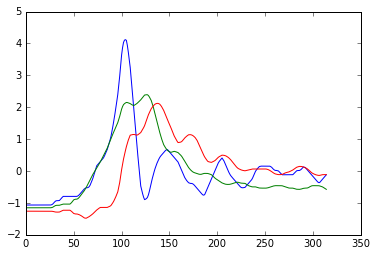

In [11]:
#plot example series
plt.plot(X_train[0,:]);

## Build model architecture

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D

In [27]:
model = Sequential()

In [28]:
model.add(Convolution1D(32, 3, border_mode='same', input_shape=(dim_length, dim_channels)))
model.add(MaxPooling1D(pool_length=2))
model.add(Convolution1D(16, 3, border_mode='same'))
model.add(Flatten())
model.add(Dense(output_dim=30)) # Fully connected layer
model.add(Activation('relu')) # Relu activation
model.add(Dense(output_dim=outputdim))
model.add(Activation("softmax")) # Final classification layer

In [29]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution1d_3 (Convolution1D)    (None, 315, 32)     320         convolution1d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)      (None, 157, 32)     0           convolution1d_3[0][0]            
____________________________________________________________________________________________________
convolution1d_4 (Convolution1D)    (None, 157, 16)     1552        maxpooling1d_1[0][0]             
____________________________________________________________________________________________________
flatten_2 (Flatten)                (None, 2512)        0           convolution1d_4[0][0]            
___________________________________________________________________________________________

Now we configure the learning process:

In [30]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=['accuracy'])

## Fit the model on the data

In [31]:
model.fit(X_train, y_train_binary, nb_epoch=10)

Epoch 1/10
627/627 [==============================] - 0s - loss: 1.9557 - acc: 0.3014     
Epoch 2/10
627/627 [==============================] - 1s - loss: 0.8881 - acc: 0.6762     
Epoch 3/10
627/627 [==============================] - 1s - loss: 0.3561 - acc: 0.8915     
Epoch 4/10
627/627 [==============================] - 1s - loss: 0.1869 - acc: 0.9346     
Epoch 5/10
627/627 [==============================] - 1s - loss: 0.1196 - acc: 0.9617     
Epoch 6/10
627/627 [==============================] - 1s - loss: 0.1190 - acc: 0.9601     
Epoch 7/10
627/627 [==============================] - 2s - loss: 0.0845 - acc: 0.9777     
Epoch 8/10
627/627 [==============================] - 1s - loss: 0.0532 - acc: 0.9904     
Epoch 9/10
627/627 [==============================] - 1s - loss: 0.0369 - acc: 0.9888     
Epoch 10/10
627/627 [==============================] - 2s - loss: 0.0514 - acc: 0.9856     


## Validate the model on validation set

In [32]:
loss_and_metrics = model.evaluate(X_val, y_val_binary, batch_size=32)
loss_and_metrics

269/269 [==============================] - 0s     


[0.40061208661160946, 0.90334572512864175]

In [33]:
classes = model.predict_classes(X_val, batch_size=32)
proba = model.predict_proba(X_val, batch_size=32)

269/269 [==============================] - 0s     


In [34]:
print(np.hstack((proba, np.vstack((classes, y_val)).transpose())))

[[  9.87026751e-01   2.74647948e-12   2.53308225e-12 ...,   7.78573437e-08
    0.00000000e+00   0.00000000e+00]
 [  2.18396146e-14   5.15791311e-15   9.99994814e-01 ...,   2.51816675e-11
    2.00000000e+00   2.00000000e+00]
 [  5.66074592e-14   1.17906616e-15   9.99893546e-01 ...,   1.69729633e-10
    2.00000000e+00   2.00000000e+00]
 ..., 
 [  1.27493013e-06   2.11296810e-06   3.91455070e-13 ...,   1.16394034e-07
    5.00000000e+00   5.00000000e+00]
 [  5.80094941e-02   5.02247632e-10   5.00203760e-06 ...,   2.17904150e-03
    5.00000000e+00   5.00000000e+00]
 [  1.72344642e-13   9.99998152e-01   7.68885045e-09 ...,   5.50384217e-11
    1.00000000e+00   1.00000000e+00]]


Let's compute some more metrics, such as the confusion matrix and the ROC curve

In [35]:
from sklearn import metrics
metrics.confusion_matrix(classes, y_val)

array([[35,  0,  0,  1,  0,  5,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  0,  0,  1,  1,  0],
       [ 1,  0,  0, 25,  1,  2,  0,  0],
       [ 0,  0,  6,  2, 39,  2,  0,  0],
       [ 2,  0,  0,  1,  0, 28,  0,  0],
       [ 0,  1,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 25]])

## Test on testset

In [36]:
loss_and_metrics = model.evaluate(X_test, y_test_binary, batch_size=32)
loss_and_metrics

3582/3582 [==============================] - 2s     


[0.32639870815091399, 0.93216080378713984]

In [37]:
#Best score by Dynamic time warping:
1 - 0.034 

0.966